# Optimal Parking
---

In crowded urban areas, attempting to find street parking near your destination can be a stressful and aggravating task. You might attempt to pull into a spot only to find you lack the space (or perhaps the skill) to fit in the narrow gap. Even worse, you might find that inconsiderate drivers have managed to take up 5 potential spots with only three vehicles. Considering varying vehicle size, perfect use of curb space in a busy environment is unlikley. What we attempt to find in this paper is an optimal parking strategy, that if followed, would lead to the most vehicles finding a spot near their destination.

To takle the problem, we consider example situations of increasing complexity, starting from a single curb and working up to a busy college residential neighborhood. 

Each driver with a specified car, skill, parking duration, distance tolerance, and parking policy. 
- For simplicity, the size of each car is modeled as a gaussian distrubution with mean of 4.25m and standard-deviation of .5m. During sampling, cars with a length of less than 3 or greater than 5.5 meters are rounded up or down to these respective bounds.
- Skills dictate what percentage greater than the length of the car is required for the driver to actually park the car if parallel parking is necessary. Though parallel parking is technically feasable in any space longer than the car itself [[1]](http://www.damtp.cam.ac.uk/user/md327/ISlecture_notes_2012.pdf), drivers will not attempt to park in any space with less than 1 meter of free-room, regardless of skill. Skill also determines how close to other cars the driver will park in the case that the space does not require parallel parking (i.e they can pull in or back in directly).
- Parking duration is the amount of time (measured in park attempts) that the driver will remain parked. For example, a driver with `park_time = 5` will vacate their parking spot after 5 other drivers attempt to park (regardless of the attempt's success).
- Distance tolerance is only implemented in some scenarios where paid parking is present. Under the assumption that paid parking is always available, distance tolerance determines how much further a driver will look beyond the closest paid parking.
- The driver policy is intended to capture the variability in driver mindset. For example, a driver in a rush will likley park less carefully than one with plenty of time. Some drivers may be more concious of leaving space for others, while some might not care and take up much more space than necessary. By manipulating the distribution of driver policies, we can observe how effectivley parking space is used in both ideal and real-world situations.

In [6]:
using Plots; gr()

Plots.GRBackend()

## Drivers & Spots

In [12]:
mutable struct driver
    car_length::Float32
    driver_skill::Float32
    parktime::Int
    policy::Int
    driverNo::Int
end

num_drivers = 100

# Car length distribution
mean_len = 4.25
len_dev = 0.5

function create_driver(driverNo, duration::Tuple{Int, Int})
    car_length = round(mean_len .+ len_dev * randn(), digits=1)
    driver_skill = abs(rand(0:0.05:0.9))
    parktime = rand(duration[1]:duration[2])
    policy = 0
    return driver(car_length, driver_skill, parktime, policy, driverNo)
end

function create_n_drivers(n, duration::Tuple{Int, Int})
    drivers = [create_driver(i, duration) for i in 1:n]
    return drivers
end

function required_space(driver::driver)
    return driver.car_length + 1 + (driver.car_length * (1-driver.driver_skill))
end

required_space (generic function with 1 method)

## A single curb

In [13]:
# scatter(1:100, [driver.car_length for driver in drivers], label = "Car Length") 
# scatter!(1:100, [driver.driver_skill for driver in drivers], label = "Driver Skill")
# plot!(required_space.(drivers), label = "Required Space")

#### Construct curb
1. set curb length

#### Car parking
1. select curb
2. find length of available open spaces on curb (spot_length)
3. if space exists that will fit car_length * driver_skill, the car will take the spot for the driver's parking duration and then vacate
4. when excess space is available (i.e. car_length * driver_skill < spot_length), allocate the extra space according to the parking policy.
    - Drivers will not perfectly fulfill the policy, rather, they will fail by driver_skill%, provided this will not cause them to hit another vehicle
5. if no space is available, the a counter ticks up and the process repeats

In [14]:
function animate_park(drivers::Vector{driver}, curb_length::Real)

    tick = 0
    no_spot = 0
    available_spaces = [(0.0, Float64(curb_length), 0)] #rear, front, driver to right (0 if none)
    parked_cars = []
    frames = size(drivers)[1]

    plot(size=(1000, 100), legend=false)
    # xticks!(0:10:curb_length)
    xaxis!(:off)
    yaxis!(:off)
    plot!([0, curb_length], [0.1, 0.1], linewidth=10, color=:black)
    xlims!(-5, curb_length + 5)
    ylims!(0, 2)

    anim = @animate for i in 1:frames
        tick += 1

        # end simulation once all of drivers have searched for a spot
        if isempty(drivers)
            break 
        end

        driver = pop!(drivers) # extract last driver from list
        req_space = required_space(driver)
        free_space = (req_space - driver.car_length)/2 #assume driver leaves same space in front/rear (change with policy)
        spot_index = 0 #track where on curb the current driver is parking
        found_spot = false
        
        # Note: this causes drivers to look for spots from start to end of curb
        for (i, (rear, front, dNo)) in enumerate(available_spaces)
            spot = front - rear # calculate length of available spot
            if spot >= req_space
                found_spot = true # driver found spot that will fit car with sufficient room
                spot_index = i
                break
            end
        end

        if found_spot
            # update available_spaces after car has parked
            rear, front, dNo_right = available_spaces[spot_index]
            car_start = rear+free_space
            car_end = car_start+driver.car_length
            splice!(available_spaces, spot_index, [(rear, car_start, driver.driverNo), (car_end, front, dNo_right)])
            # add driver to list of parked cars
            push!(parked_cars, (car_start, car_end, driver.parktime, driver.driverNo))
            plot!([car_start, car_end], [1, 1], linewidth=5, label="")
        else
            no_spot += 1 # update number of divers unable to park
        end

        # update parktime for each of the parked vehicles
        if !isempty(parked_cars)
            parked_cars = map(x -> (x[1], x[2], x[3] - 1, x[4]), parked_cars)
        end

        # reduce time left in spot, if zero, remove driver from parked cars list and reallocate their spot to available_spaces
        for (i, (car_start, car_end, parktime, driverNo)) in enumerate(parked_cars)
            if parktime <= 0
                deleteat!(parked_cars, i)
                parking_space = findfirst(x -> x[3] == driverNo, available_spaces)
                now_available = (available_spaces[parking_space][1], available_spaces[parking_space+1][2], available_spaces[parking_space+1][3])
                splice!(available_spaces, parking_space:parking_space+1, [now_available])
                plot!([car_start, car_end], [1, 1], linewidth=6, color=:white, label="")
            end
        end
    end

    println("Run Complete:")
    residual_space = curb_length - sum(map(x -> (x[2] - x[1]), parked_cars))
    println("\tThere were ", round(residual_space, digits = 3), " meters of unused curb space at end of simulation. (",
             round(100(residual_space/curb_length), digits = 3), "%)")
    println("\t", no_spot, " out of ", frames, " drivers were unable to find a spot.")

    gif(anim, "cars_animation.gif", fps = 10) # Save the animation as a GIF file
end

animate_park (generic function with 1 method)

Run Complete:
	There were 21.3 meters of unused curb space at end of simulation. (42.6%)
	298 out of 400 drivers were unable to find a spot.


┌ Info: Saved animation to c:\Users\Aidan\Documents\GitHub\OptimalParking.jl\OptimalParking\src\cars_animation.gif
└ @ Plots C:\Users\Aidan\.julia\packages\Plots\esM5q\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\Aidan\\Documents\\GitHub\\OptimalParking.jl\\OptimalParking\\src\\cars_animation.gif")
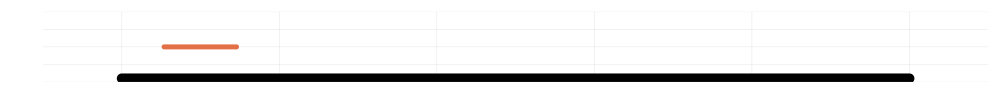

In [15]:
curb_length = 50.0
drivers = create_n_drivers(400, (10,50))

animate_park(drivers, curb_length)

# TODO

1. Add option to `park` so that drivers prefer bigger spaces (right now they always take the first spot that fits their car and skill level)
2. Create driver policies to determine how they will chose a spot
3. Compartmentalize functions as much as possible
4. Create gif animation of parking lot over time